In this notebook, I load the xlsx containing metadata for all the samples, and prune so it only contains samples both present in Alans joint call and the metadata file.
Afterwards, I generate some additional information to add to the metadata.

In [1]:
%run ../scripts/notebook_settings.py

As i only care about the samples present, no calldata fields has to be loaded.
I also note that it is not tabix indexed - the best solution is probably to transform the files into zarr.

In [2]:
meta_data_samples = pd.read_excel("../data/Papio_Genomes_Geoloc_All_Individuals.xlsx")
meta_data_samples.PGDP_ID = meta_data_samples.PGDP_ID.astype(str)

Opening both in vcf and zarr format to compare

In [3]:
vcf_dir = "/faststorage/project/primatediversity/data/PG_baboons_pananu3_23_2_2021/output.filtered.snps.chrX.removed.AB.pass.vep.vcf.gz"
vcf_callset = allel.read_vcf(vcf_dir)

In [4]:
meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(vcf_callset["samples"])]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude
0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M,"SDSU Captive Wildlife Research Facility, Brook...",-96.793280,44.334031
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
...,...,...,...,...,...,...,...,...,...,...
226,34449,34449_BZ11022,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557
228,34474,34474_BZ11050,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557
229,97074,97074,Jolly/Phillips-Conroy,Papio,hamadryas,"Awash, Ethiopia",F,"አዋሽ / Awash, Zone 3, አፋር ክልል / Afar, ኢትዮጵያ",40.167674,8.992496
230,97124,97124,Jolly/Phillips-Conroy,Papio,hamadryas,"Awash, Ethiopia",M,"አዋሽ / Awash, Zone 3, አፋር ክልል / Afar, ኢትዮጵያ",40.167674,8.992496


In [5]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")

In [6]:
callset["samples"]

<zarr.core.Array '/samples' (227,) object read-only>

In [7]:
meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(callset["samples"])]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude
0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M,"SDSU Captive Wildlife Research Facility, Brook...",-96.793280,44.334031
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
...,...,...,...,...,...,...,...,...,...,...
226,34449,34449_BZ11022,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557
228,34474,34474_BZ11050,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557
229,97074,97074,Jolly/Phillips-Conroy,Papio,hamadryas,"Awash, Ethiopia",F,"አዋሽ / Awash, Zone 3, አፋር ክልል / Afar, ኢትዮጵያ",40.167674,8.992496
230,97124,97124,Jolly/Phillips-Conroy,Papio,hamadryas,"Awash, Ethiopia",M,"አዋሽ / Awash, Zone 3, አፋር ክልል / Afar, ኢትዮጵያ",40.167674,8.992496


All individuals in the vcf is in, which is all non-captive individuals + the captive geladas.

Now we have reached later, and I am going to use what I have found in the dp02 to add some extra data per individual

In [8]:
callset = zarr.open_group(zarr_dir, mode='r')
gt = allel.GenotypeArray(callset["calldata/GT"])

In [9]:
samples_list = list(callset['samples'][:])
metadata_present_samples = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(samples_list)].copy()

In [10]:
#Code burrowed from Kasper to make the callset_indexes.
samples_callset_index = [samples_list.index(s) for s in metadata_present_samples.PGDP_ID]
metadata_present_samples['callset_index'] = samples_callset_index
metadata_present_samples

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index
0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M,"SDSU Captive Wildlife Research Facility, Brook...",-96.793280,44.334031,9
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,10
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,11
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,12
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,13
...,...,...,...,...,...,...,...,...,...,...,...
226,34449,34449_BZ11022,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,4
228,34474,34474_BZ11050,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,5
229,97074,97074,Jolly/Phillips-Conroy,Papio,hamadryas,"Awash, Ethiopia",F,"አዋሽ / Awash, Zone 3, አፋር ክልል / Afar, ኢትዮጵያ",40.167674,8.992496,7
230,97124,97124,Jolly/Phillips-Conroy,Papio,hamadryas,"Awash, Ethiopia",M,"አዋሽ / Awash, Zone 3, አፋር ክልል / Afar, ኢትዮጵያ",40.167674,8.992496,8


There are too many Origins to easily color, so I am going to group some origins

In [11]:
for s in metadata_present_samples["Species"].unique():
    print(s)
    s_df = metadata_present_samples.loc[metadata_present_samples.Species == s]
    print(s_df["Origin"].value_counts())

gelada
captive    2
Name: Origin, dtype: int64
anubis
Gog Woreda, Gambella region, Ethiopia    25
Lake Manyara, Tanzania                   19
Gombe, Tanzania                          17
Serengeti, Tanzania                      14
Tarangire, Tanzania                       7
Ngorongoro, Tanzania                      6
Arusha, Tanzania                          4
Aberdare, Kenya                           2
Name: Origin, dtype: int64
cynocephalus
Mikumi, Tanzania         38
Mahale, Tanzania          7
Ruaha, Tanzania           6
Udzungwa, Tanzania        5
Selous, Tanzania          3
Katavi, Tanzania          2
Issa Valley, Tanzania     1
Name: Origin, dtype: int64
papio
Niokolo-Koba, Senegal    12
Name: Origin, dtype: int64
ursinus (grayfoot)
Dendro Park, Zambia    4
Name: Origin, dtype: int64
hamadryas
Filoha, Ethiopia    24
Awash, Ethiopia      2
Name: Origin, dtype: int64
kindae
Chunga, Zambia    27
Name: Origin, dtype: int64


Cluster Tarangire, Ngorongoro and Arusha for anubis (Northern Tanzania)
Cluster Mahale, Katavi, Issa Valley (Western Tanzania)
Cluster Ruaha, Udzungwa, Selous (Central Tanzania)

In [12]:
c_origin = []
for i, row in metadata_present_samples.iterrows():
    if row.Origin in ["Gog Woreda, Gambella region, Ethiopia"]:
        c_origin.append("Anubis, Ethiopia")
    elif row.Origin in ["Aberdare, Kenya"]:
        c_origin.append("Anubis, Kenya")
    elif row.Species =="anubis":
        c_origin.append("Anubis, Tanzania")
    elif row.Origin in ["Mahale, Tanzania", "Katavi, Tanzania", "Issa Valley, Tanzania"]:
        c_origin.append("Cynocephalus, Western Tanzania")
    elif row.Species == "cynocephalus":
        c_origin.append("Cynocephalus, Central Tanzania")
    elif row.Species == "papio":
        c_origin.append("Papio, Senegal")
    elif row.Species == "ursinus (grayfoot)":
        c_origin.append("Ursinus, Zambia")
    elif row.Species == "hamadryas":
        c_origin.append("Hamadryas, Ethiopia")
    elif row.Species == "kindae":
        c_origin.append("Kindae, Zambia")
    elif row.Species == "gelada":
        c_origin.append("Gelada, Captive")
metadata_present_samples["C_origin"] = c_origin

These settings are done due to heterozygosity investigation.

In [13]:
metadata_present_samples.loc[metadata_present_samples.PGDP_ID=="PD_0202", "Sex"] = "M"
metadata_present_samples.loc[metadata_present_samples.PGDP_ID=="PD_0690", "Sex"] = "M"
metadata_present_samples.loc[metadata_present_samples.PGDP_ID=="30877", "Sex"] = "M"
metadata_present_samples.loc[metadata_present_samples.PGDP_ID=="30977", "Sex"] = "F"
metadata_present_samples.loc[metadata_present_samples.PGDP_ID=="38168", "Sex"] = "M"

It is best if the metadata and callset samples has the same ordering, so I reorder the met

In [14]:
metadata_present_samples = metadata_present_samples.sort_values(by=["callset_index"]).reset_index(drop=True)
metadata_present_samples.to_csv("../data/Papio_metadata_with_clustering.txt", sep = " ", index=False)

In [15]:
metadata_present_samples

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin
0,16066,16066_3130,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,0,"Cynocephalus, Central Tanzania"
1,16098,16098_5026,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,1,"Cynocephalus, Central Tanzania"
2,30877,30877_3426,James Else,Papio,anubis,"Aberdare, Kenya",M,"Aberdare National Park, Nyeri, Central Kenya, ...",36.712451,-0.410251,2,"Anubis, Kenya"
3,30977,30977_3373,James Else,Papio,anubis,"Aberdare, Kenya",F,"Aberdare National Park, Nyeri, Central Kenya, ...",36.712451,-0.410251,3,"Anubis, Kenya"
4,34449,34449_BZ11022,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,4,"Kindae, Zambia"
...,...,...,...,...,...,...,...,...,...,...,...,...
222,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,222,"Kindae, Zambia"
223,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,223,"Kindae, Zambia"
224,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,224,"Kindae, Zambia"
225,PD_0793,34422_BZ11070,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",M,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,225,"Kindae, Zambia"


See dp02 for more detailed comments on the next part

<AxesSubplot:xlabel='m', ylabel='Count'>

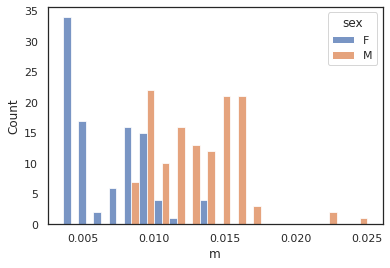

In [16]:
missingness = gt.is_missing()
m_per_i = sum(missingness)
total_sites = len(gt)
d = {"m": m_per_i/total_sites, "ID": metadata_present_samples["PGDP_ID"], "sex": metadata_present_samples["Sex"]}
m_df = pd.DataFrame(data=d)
sns.histplot(m_df, x="m", hue="sex", multiple="dodge", bins=20)

In [17]:
m_df.loc[m_df.m > 0.02]

,m,ID,sex
6,0.022163,38168,M
8,0.021821,97124,M
9,0.024995,PD_0067,M


In [18]:
metadata_present_samples.loc[metadata_present_samples.PGDP_ID =="97124"]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin
8,97124,97124,Jolly/Phillips-Conroy,Papio,hamadryas,"Awash, Ethiopia",M,"አዋሽ / Awash, Zone 3, አፋር ክልል / Afar, ኢትዮጵያ",40.167674,8.992496,8,"Hamadryas, Ethiopia"


The gelada individuals are the two worst outliers, together with 97124. As the ref is anubis, it makes sense that gelada has worse mapping.

In [19]:
m_df.loc[(m_df.m > 0.01) & (m_df.sex == "F")]

,m,ID,sex
0,0.013908,16066,F
1,0.013826,16098,F
4,0.013498,34449,F
5,0.013767,34474,F
7,0.011788,97074,F
213,0.010492,PD_0781,F
220,0.010075,PD_0788,F
221,0.010196,PD_0789,F
224,0.010119,PD_0792,F


The sciadv individuals in general have more missingness, but not drastically more than the worst individuals in the newer sampling.

In [20]:
metadata_present_samples["x_missing"] = m_per_i/total_sites
metadata_present_samples

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin,x_missing
0,16066,16066_3130,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,0,"Cynocephalus, Central Tanzania",0.013908
1,16098,16098_5026,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,1,"Cynocephalus, Central Tanzania",0.013826
2,30877,30877_3426,James Else,Papio,anubis,"Aberdare, Kenya",M,"Aberdare National Park, Nyeri, Central Kenya, ...",36.712451,-0.410251,2,"Anubis, Kenya",0.015562
3,30977,30977_3373,James Else,Papio,anubis,"Aberdare, Kenya",F,"Aberdare National Park, Nyeri, Central Kenya, ...",36.712451,-0.410251,3,"Anubis, Kenya",0.009998
4,34449,34449_BZ11022,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,4,"Kindae, Zambia",0.013498
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,222,"Kindae, Zambia",0.009835
223,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,223,"Kindae, Zambia",0.009672
224,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,224,"Kindae, Zambia",0.010119
225,PD_0793,34422_BZ11070,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",M,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,225,"Kindae, Zambia",0.014323


In [21]:
metadata_present_samples.loc[metadata_present_samples.PGDP_ID=="PD_0202"]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin,x_missing
13,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,13,"Anubis, Tanzania",0.010041


In [22]:
(metadata_present_samples.Sex == "U").sum()

0

In [23]:
metadata_present_samples.to_csv("../data/metadata_with_x_missing.txt", sep = " ", index=False)